In [626]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pygad
import logging
import random

In [627]:
arr = pd.read_csv("phylo.csv",
                 delimiter=",")
display(arr)

,Unnamed: 0,Phylostratum,GeneID,Zygote,Quadrant,Globular,Heart,Torpedo,Bent,Mature
0,1,1,at1g01040.2,2173.635205,1911.200145,1152.555283,1291.422445,1000.252931,962.977223,1696.427421
1,2,1,at1g01050.1,1501.014084,1817.308557,1665.308874,1564.761244,1496.320663,1114.643547,1071.655487
2,3,1,at1g01070.1,1212.792724,1233.002267,939.200046,929.619501,864.218009,877.206001,894.818917
3,4,1,at1g01080.2,1016.920321,936.383717,1181.338144,1329.473434,1392.642854,1287.974590,861.260488
4,5,1,at1g01090.1,11424.566680,16778.168460,34366.649350,39775.640530,56231.568920,66980.367330,7772.561656
...,...,...,...,...,...,...,...,...,...,...
25255,25256,12,at5g67200.1,721.139701,731.211686,788.833156,815.185775,871.509726,809.404700,749.102579
25256,25257,12,at5g67245.1,1132.810160,1145.611552,1030.842523,1142.514730,1175.351616,985.904374,1147.261206
25257,25258,12,at5g67280.1,731.678348,748.688731,705.033813,622.710117,730.698691,864.307779,774.050852
25258,25259,12,at5g67380.1,14725.097780,2426.968469,2463.236828,2395.512964,1847.669032,1943.984418,5137.928045


In [628]:
ex_data = arr[["Zygote", "Quadrant","Globular","Heart","Torpedo","Bent","Mature"]]

In [629]:
var_ex = ex_data.var(axis=1)/ex_data.mean(axis=1) 
age_weighted = ex_data.mul(arr["Phylostratum"], axis=0)
perc = 1
high_var_ind =  np.argsort(var_ex)[-round(len(var_ex) * perc):]
low_var_ind =  np.argsort(var_ex)[:-round(len(var_ex) * perc)]


In [630]:
high_var_w = age_weighted.iloc[high_var_ind,:]
high_var = ex_data.iloc[high_var_ind,:]
low_var_w = age_weighted.iloc[low_var_ind,:]
low_var = ex_data.iloc[low_var_ind,:]


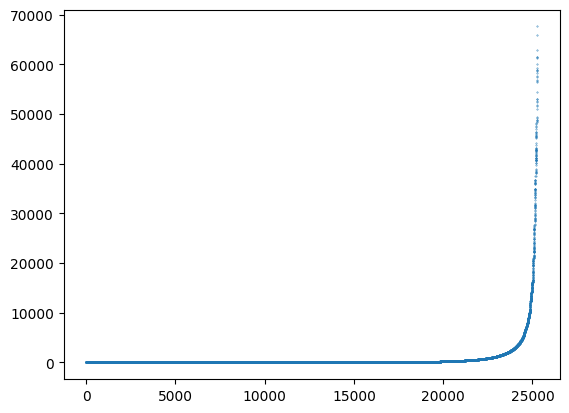

In [631]:
plt.scatter(range(len(var_ex)),sorted(var_ex),s=0.1)

In [632]:
low_var_w_sum = low_var_w.sum(axis=0).to_numpy()
low_var_sum = low_var.sum(axis=0).to_numpy()

len_low_var =low_var.shape[0]

In [633]:
def fitness2(ga_instance, solution, solution_idx):
    up = np.add(high_var_w.mul(solution, axis=0).sum(axis=0).to_numpy(),low_var_w_sum)
    down = np.add(low_var_sum, high_var.mul(solution, axis=0).sum(axis=0).to_numpy())
    avgs = np.divide(up,down)
    return - np.var(avgs)
    

In [645]:

def fitness(ga_instance, solution, solution_idx):
    up = np.add(high_var_w.iloc[np.where(solution == 1)[0],:].sum(axis=0).to_numpy(),low_var_w_sum)
    down = np.add(low_var_sum, high_var.iloc[np.where(solution == 1)[0],:].sum(axis=0).to_numpy())
    avgs = np.divide(up,down)
    return - np.var(avgs) + (sum(solution)/len(solution))**2*1.e-4

In [635]:
def create_population(size):
    return np.array([random.choices([0,1], weights=(1, 20), k=high_var.shape[0]) for _  in range(size)])

In [636]:
population = create_population(100)

In [646]:
level = logging.DEBUG
name = 'logfile.txt'

logger = logging.getLogger(name)
logger.setLevel(level)


console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
console_format = logging.Formatter('%(message)s')
console_handler.setFormatter(console_format)
logger.addHandler(console_handler)

ga_instance = pygad.GA(num_generations=30,
                       num_parents_mating=20,
                       sol_per_pop=100,
                       initial_population=population,
                       parent_selection_type="sss",
                       crossover_probability=0.2,
                       mutation_type="adaptive",
                       mutation_probability=(0.1, 0.025),
                       K_tournament=2,
                       fitness_func=fitness,
                       init_range_low=0,
                       init_range_high=2,
                       gene_type=int,
                       crossover_type="uniform",
                       parallel_processing=["thread", 6],
                       save_best_solutions=True,
                       keep_elitism=1,
                       save_solutions=True
                       )

ga_instance.run()

solution, solution_fitness, solution_idx = ga_instance.best_solution()

/usr/local/lib/python3.10/site-packages/pygad/pygad.py:1074: UserWarning: Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.")
/usr/local/lib/python3.10/site-packages/pygad/pygad.py:1083: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


In [640]:
def print_curve(solution,label=None):
    up = np.add(high_var_w.iloc[np.where(solution == 1)[0],:].sum(axis=0).to_numpy(),low_var_w_sum)
    down = np.add(low_var_sum, high_var.iloc[np.where(solution == 1)[0],:].sum(axis=0).to_numpy())
    avgs = np.divide(up,down)
    print(np.var(avgs))
    plt.ylim(3, 3.8)
    plt.plot(list(range(7)),avgs,'-o',label=label)
    if label:
        plt.legend()
    

6.664053333284268e-06


9295

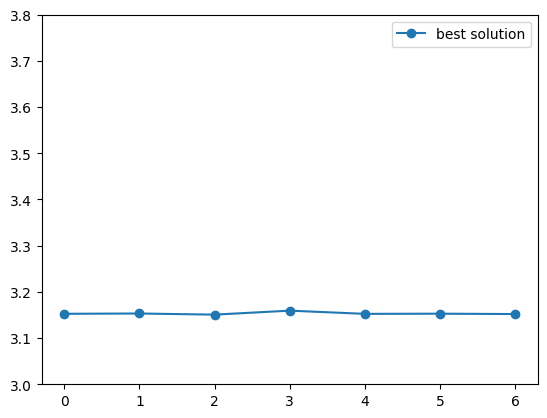

In [647]:
print_curve(solution,label="best solution")
len(np.where(solution == 0)[0])


In [643]:
set(ga_instance.best_solutions_fitness)

{-0.008002420820092473,
 -0.006758295581567763,
 -0.006080009936350435,
 -0.005186200475970659,
 -0.004187769833972214,
 -0.0034686220129877396,
 -0.0030473190703970594,
 -0.00228534146513577,
 -0.0017535756453661835,
 -0.0011954877583192458,
 -0.0008144114407243872,
 -0.000509835218948298,
 -0.0003619693337260581,
 -9.145407629234634e-05,
 5.0486853130083536e-05,
 9.580613642575387e-05,
 0.0001693467969783547,
 0.00018514851223614285,
 0.00020896758518882283,
 0.00022286335066134538,
 0.00024684314145197856,
 0.0002657085193922295}

0.0002657085193922295


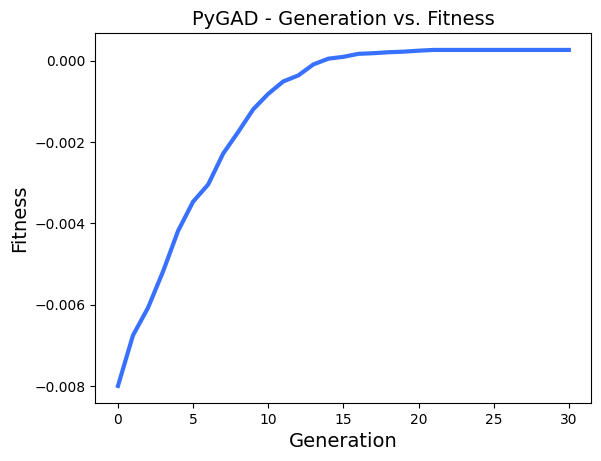

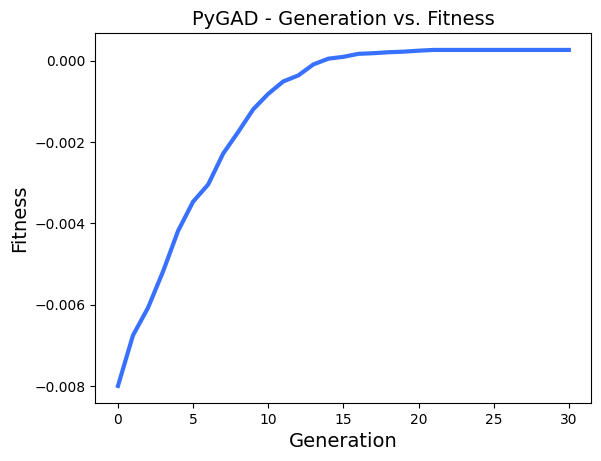

In [642]:
print(solution_fitness)
ga_instance.plot_fitness()

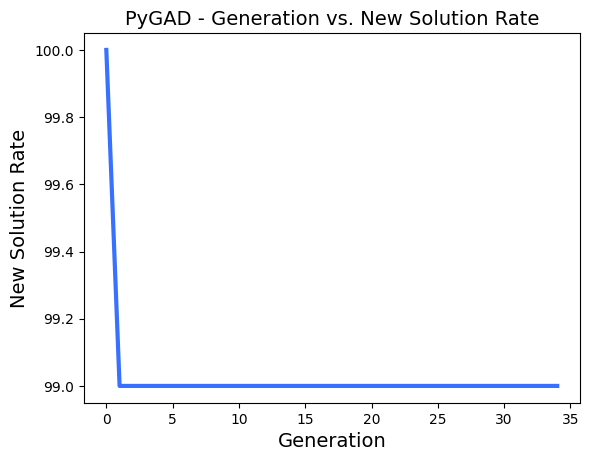

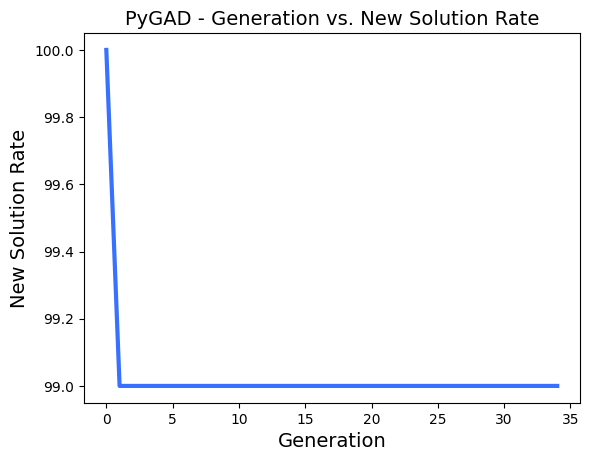

In [510]:
ga_instance.plot_new_solution_rate()

In [511]:
print(solution_fitness)

2.2615630143426646e-06


/var/folders/pw/r8s9dk9x4z56sfjh5qm3t8gw0002n8/T/ipykernel_70162/2972284964.py:4: RuntimeWarning: invalid value encountered in divide
  avgs = np.divide(up,down)


nan


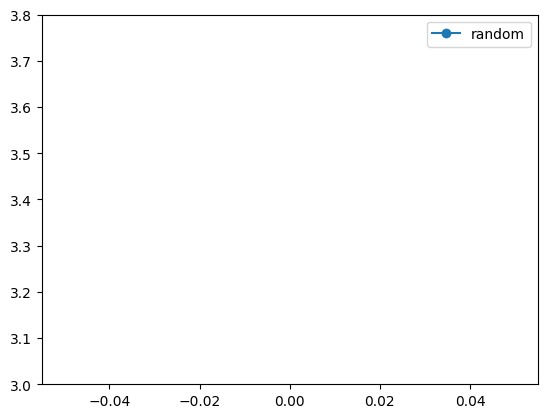

In [531]:
print_curve(np.random.randint(0,1, size=high_var.shape[0]),label="random")

0.009837646583158657


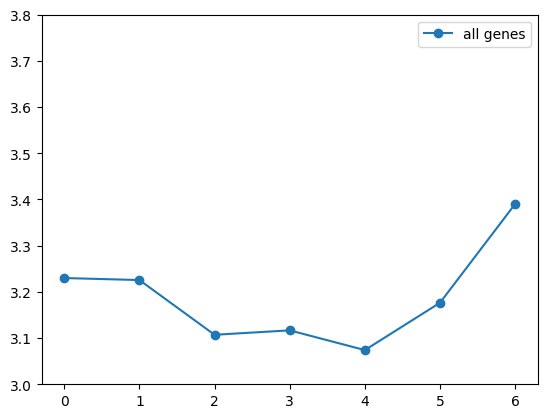

In [532]:
print_curve(np.ones(high_var.shape[0]), label="all genes")